This notebook is follow the [Demo1](https://colab.research.google.com/drive/1DRAzLUPxsd-0r8b-o4nlyFXrjw_ZajJJ?usp=sharing#scrollTo=Mj9LXMpJ01d7).

Use [Lag-Llama](https://github.com/time-series-foundation-models/lag-llama)

Important Notes 
- Lag-Llama needs a minimum context of `32` timestamps before the prediction timestamp starts. 
- Demo1 uses the tutorial by the authors of GluonTS at https://ts.gluon.ai/stable/tutorials/data_manipulation/pandasdataframes.html
- Demo1 demonstrates how to do with long and wide dataframe. We adopte wide version.

# Pre

In [1]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from lag_llama.gluon.estimator import LagLlamaEstimator

/home/hchuang/anaconda3/envs/lag-llama/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd

In [2]:
import sys
from types import ModuleType

# Create dummy module hierarchy
def create_dummy_module(module_path):
    """
    Create a dummy module hierarchy for the given path.
    Returns the leaf module.
    """
    parts = module_path.split('.')
    current = ''
    parent = None

    for part in parts:
        current = current + '.' + part if current else part
        if current not in sys.modules:
            module = ModuleType(current)
            sys.modules[current] = module
            if parent:
                setattr(sys.modules[parent], part, module)
        parent = current

    return sys.modules[module_path]

# Create the dummy gluonts module hierarchy
gluonts_module = create_dummy_module('gluonts.torch.modules.loss')

# Create dummy classes for the specific loss functions
class DistributionLoss:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

class NegativeLogLikelihood:
    def __init__(self, *args, **kwargs):
        pass

    def __call__(self, *args, **kwargs):
        return 0.0

    def __getattr__(self, name):
        return lambda *args, **kwargs: None

# Add the specific classes to the module
gluonts_module.DistributionLoss = DistributionLoss
gluonts_module.NegativeLogLikelihood = NegativeLogLikelihood

## Lag-Llama prediction function
We create a function for Lag-Llama inference that we can reuse for all different types of dataset below. This function returns the predictions for the given prediction horizon. The forecast will be of shape (num_samples, prediction_length), where num_samples is the number of samples sampled from the predicted probability distribution for each timestep.

In [3]:
def get_lag_llama_predictions(dataset, prediction_length, device, context_length=32, use_rope_scaling=False, num_samples=100):
    ckpt = torch.load("lag-llama.ckpt", map_location=device, weights_only = False) # Uses GPU since in this Colab we use a GPU.
    estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    }

    estimator = LagLlamaEstimator(
        ckpt_path="lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length, # Lag-Llama was trained with a context length of 32, but can work with any context length

        # estimator args
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments if use_rope_scaling else None,

        batch_size=1,
        num_parallel_samples=100,
        device=device,
    )

    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset,
        predictor=predictor,
        num_samples=num_samples
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)

    return forecasts, tss

# Wide data in demo case

In [6]:
url_wide = (
    "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
    "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
)
df_wide = pd.read_csv(url_wide, index_col=0, parse_dates=True)

print(df_wide.shape)
print(type(df_wide.index))
print(df_wide.tail())

(240, 10)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
                          A       B       C       D       E       F       G  \
2021-01-10 19:00:00  0.7328  0.6937 -0.3679 -0.6389 -1.3643  0.1667  0.3918   
2021-01-10 20:00:00  0.4957  0.7043 -0.5553 -0.8691 -1.8283  0.0413  0.8977   
2021-01-10 21:00:00 -0.1209  0.5297 -0.7084 -1.0384 -2.0439  0.0534  1.3973   
2021-01-10 22:00:00 -0.5072  0.5816 -0.5735 -1.3990 -2.1105 -0.0674  1.3225   
2021-01-10 23:00:00 -0.6661  0.3736 -0.5547 -1.2383 -2.2506 -0.1309  1.8509   

                          H       I       J  
2021-01-10 19:00:00 -0.4162  0.9811  1.2349  
2021-01-10 20:00:00 -0.5412  1.0969  1.1525  
2021-01-10 21:00:00 -0.6366  1.1286  1.1485  
2021-01-10 22:00:00 -0.5672  1.0786  1.3248  
2021-01-10 23:00:00 -0.9130  0.9624  1.1657  


# AR

In [8]:
# Read AR dataset

sys.path.append("/home/hchuang/Documents/Project/Package/my_dataset")
from my_dataset.datasets.load_data import load_datasets
data_dict = load_datasets('AR1')

test100_npy = np.squeeze(data_dict['test_100.npy']) # reduce useless dimension ((1000, 100, 1) -> (1000, 100))
df_wide = pd.DataFrame(test100_npy).T
print(df_wide.shape)
# df_wide.head()


(100, 1000)


In [9]:
# Pre-process

# (new)Generate a DatetimeIndex for PandasDataset(dict(df_wide))
dt_index = pd.date_range(start="2024-01-01", periods=100, freq="D")
df_wide.index = dt_index

# Convert numerical columns to float 32 format for lag-llama
for col in df_wide.columns:
    # Check if column is not of string type
    if df_wide[col].dtype != 'object' and pd.api.types.is_string_dtype(df_wide[col]) == False:
        df_wide[col] = df_wide[col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dict(df_wide))

In [10]:
# Prediction

backtest_dataset = ds
prediction_length = 1  # Define your prediction length (e.g., 24 here since the data frequency is hourly).
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment


forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples = num_samples) # (new) note that num_samples is optional argu, need to specify

In [11]:
# Evaluation
actual = test100_npy[:,-2]*0.8
pred = np.array([np.mean(forecasts[i].samples) for i in range(len(forecasts))])

mse = np.mean((pred - actual) ** 2)
std_err = np.std(((pred - actual)**2))

print(f"MSE with t-1: {round(mse,4)}")
print(f"std err: {round(std_err,4)}")

# Evaluation
actual = test100_npy[:,-1]
pred = np.array([np.mean(forecasts[i].samples) for i in range(len(forecasts))])

mse = np.mean((pred - actual) ** 2)
std_err = np.std(((pred - actual)**2))

print(f"MSE : {round(mse,4)}")
print(f"std err: {round(std_err,4)}")

actual = test100_npy[:,-2]
pred = np.array([np.mean(forecasts[i].samples) for i in range(len(forecasts))])

mse = np.mean((pred - actual) ** 2)
std_err = np.std(((pred - actual)**2))

print(f"MSE : {round(mse,4)}")
print(f"std err: {round(std_err,4)}")

actual = test100_npy[:,-3]
pred = np.array([np.mean(forecasts[i].samples) for i in range(len(forecasts))])

mse = np.mean((pred - actual) ** 2)
std_err = np.std(((pred - actual)**2))

print(f"MSE : {round(mse,4)}")
print(f"std err: {round(std_err,4)}")



MSE with t-1: 0.0535
std err: 0.0782
MSE : 1.0478
std err: 1.5542
MSE : 0.0948
std err: 0.1559
MSE : 1.0619
std err: 1.5967


In [12]:
actual = test100_npy[:,-2]*0.8
pred = test100_npy[:,-2]

mse = np.mean((pred - actual) ** 2)
std_err = np.std(((pred - actual)**2))
print(f"MSE : {round(mse,4)}")
print(f"std err: {round(std_err,4)}")



MSE : 0.1179
std err: 0.1658


### Report

In [ ]:
metric1 = []
metric2 = []
for i in [10,50,100,500,1000]:
    # Prediction

    backtest_dataset = ds
    prediction_length = 1  # Define your prediction length (e.g., 24 here since the data frequency is hourly).
    num_samples = i # number of samples sampled from the probability distribution for each timestep
    device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment


    forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples = num_samples) # (new) note that num_samples is optional argu, need to specify
    
    # Evaluation
    actual = test100_npy[:,-2]*0.8
    pred = np.array([np.mean(forecasts[i].samples) for i in range(len(forecasts))])

    metric1.append(np.mean((pred - actual) ** 2))
    metric2.append(np.std(((pred - actual)**2)))


In [89]:
metric1

[np.float64(0.10737860829353586),
 np.float64(0.05624507111481782),
 np.float64(0.051841440085548765),
 np.float64(0.04833828556626208),
 np.float64(0.047159817438216865)]

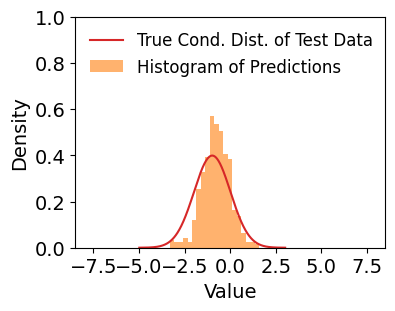

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

# Index settings
index = 0
pre_lag1 = 1  # Position index of T-1

# Data Preparation ----------------
## Normal Distribution
mean = test100_npy[0,-2].flatten() * 0.8
std_dev = 1
x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
y = norm.pdf(x, mean, std_dev)

## Histogram Data
data = forecasts[0].samples.flatten()

# Plot ----------------
plt.figure(figsize=(4, 3))

# Colors
colors = ['tab:red', 'tab:orange', 'tab:purple', 'tab:blue', 'tab:green']

# Normal Distribution Curve
plt.plot(x, y, label='True Cond. Dist. of Test Data', color=colors[0], alpha=1)

# Histogram
plt.hist(data, bins=20, density=True, alpha=0.6, label='Histogram of Predictions', color=colors[1])

# Set limits
plt.ylim(0, 1)  # Y-axis range
plt.xlim(-8.5, 8.5)  # X-axis range

# Labels and Formatting
plt.xlabel('Value', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Legend
plt.legend(frameon=False, fontsize=12, loc='upper left')

# Show plot
plt.show()


# N(0,1)

In [118]:
test100_npy = np.random.randn(1000, 100)
df_wide = pd.DataFrame(test100_npy).T
print(df_wide.shape)

(100, 1000)


In [119]:
# Pre-process

# (new)Generate a DatetimeIndex for PandasDataset(dict(df_wide))
dt_index = pd.date_range(start="2024-01-01", periods=100, freq="D")
df_wide.index = dt_index

# Convert numerical columns to float 32 format for lag-llama
for col in df_wide.columns:
    # Check if column is not of string type
    if df_wide[col].dtype != 'object' and pd.api.types.is_string_dtype(df_wide[col]) == False:
        df_wide[col] = df_wide[col].astype('float32')

# Create a PandasDataset
ds = PandasDataset(dict(df_wide))

# Prediction

backtest_dataset = ds
prediction_length = 1  # Define your prediction length (e.g., 24 here since the data frequency is hourly).
num_samples = 100 # number of samples sampled from the probability distribution for each timestep
device = torch.device("cuda:0") # You can switch this to CPU or other GPUs if you'd like, depending on your environment


forecasts, tss = get_lag_llama_predictions(backtest_dataset, prediction_length, device, num_samples = num_samples) # (new) note that num_samples is optional argu, need to specify

In [120]:
# Evaluation
actual = test100_npy[:,-1]
pred = np.array([np.mean(forecasts[i].samples) for i in range(len(forecasts))])

mse = np.mean((pred - actual) ** 2)
std_err = np.std(((pred - actual)**2))

print(f"MSE : {round(mse,4)}")
print(f"std err: {round(std_err,4)}")

actual = test100_npy[:,-2]
pred = np.array([np.mean(forecasts[i].samples) for i in range(len(forecasts))])

mse = np.mean((pred - actual) ** 2)
std_err = np.std(((pred - actual)**2))

print(f"MSE : {round(mse,4)}")
print(f"std err: {round(std_err,4)}")

actual = test100_npy[:,-3]
pred = np.array([np.mean(forecasts[i].samples) for i in range(len(forecasts))])

mse = np.mean((pred - actual) ** 2)
std_err = np.std(((pred - actual)**2))

print(f"MSE : {round(mse,4)}")
print(f"std err: {round(std_err,4)}")


MSE : 1.1655
std err: 1.603
MSE : 0.7127
std err: 0.9153
MSE : 1.01
std err: 1.5823
